In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
import cftime 
import psutil
import xesmf as xe

In [39]:


import cartopy.crs as ccrs
import cartopy

import matplotlib.pyplot as plt

In [3]:
from src.multi_model_large_ensemble import MultiModelLargeEnsemble

In [33]:
import dask

In [34]:
def convert_longitude_360to180(ds):
    """Convert ds from 0 to 360 longitude to -180 to 180 coordinate

    Parameters
    ----------
    ds: xr.Dataset
        CMIP model dataset

    Returns
    -------
    ds: xr.Dataset
        Same CMIP dataset with converted longitude
    """
    ds = ds.assign_coords({'lon': ds.lon.where(ds.lon <= 180, ds.lon - 360)})
    # To silence large chunk warning
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        ds = ds.sortby(ds.lon)
    return ds

## Global loading

In [4]:
mmle = MultiModelLargeEnsemble(['MIROC6', 'cesm_lens', 'CanESM5', 'MPI-ESM1-2-LR'], 'tas', 'day', 
                               lat=slice(None, None), lon=slice(None, None), 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

In [5]:
mmle.compute_x(x_type='quantile_return', load=True, name='default_quantile_return_10yr')

Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/default_quantile_return_10yr/MIROC6.zarr
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/default_quantile_return_10yr/cesm_lens.zarr
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/default_quantile_return_10yr/CanESM5.zarr
Saving: gcs://climateai_data_repository/tmp/global_cmip_2.5deg/default_quantile_return_10yr/MPI-ESM1-2-LR.zarr


In [6]:
mmle.x.load()

<xarray.DataArray 'tas' (model: 4, member_id: 50, time: 181, lat: 71, lon: 144)>
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]])
Coordinates:
  * model      (model) <U13 'MIROC6' 'cesm_lens' 'CanESM5' 'MPI-ESM1-2-LR'
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
  * time       (time) datetime64[ns] 1920-01-01 1921-01-01 ... 2100-01-01
  * lat        (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    q_values   (model, lat, lon) float64 267.6 267.4 267.3 ... 273.7 273.7 273.7
    quantile   (model) float64 0.9997 0.9997 0.9997 0.9997

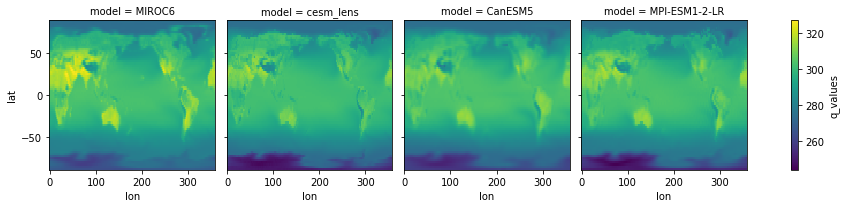

In [9]:
mmle.x.q_values.plot(col='model')

In [10]:
mmle.compute_LE()

/opt/conda/envs/carla/lib/python3.9/site-packages/xarray/core/nputils.py:155: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [29]:
mmle.results

<xarray.Dataset>
Dimensions:       (time: 181, lat: 71, lon: 144, model: 4)
Coordinates:
  * time          (time) datetime64[ns] 1920-01-01 1921-01-01 ... 2100-01-01
  * lat           (lat) float64 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * model         (model) <U13 'MIROC6' 'cesm_lens' 'CanESM5' 'MPI-ESM1-2-LR'
    q_values      (model, lat, lon) float64 267.6 267.4 267.3 ... 273.7 273.7
    quantile      (model) float64 0.9997 0.9997 0.9997 0.9997
Data variables:
    M_LE          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    I_LE          (model, time, lat, lon) float64 nan nan nan ... nan nan nan
    Ibar_LE       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    T_LE          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_M_LE     (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    frac_Ibar_LE  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

In [35]:
results  = convert_longitude_360to180(mmle.results)

In [28]:
#mmle.results['frac_M_LE'] = mmle.results['M_LE'] / (mmle.results['M_LE'] + mmle.results['Ibar_LE'])
mmle.results['frac_Ibar_LE'] = mmle.results['Ibar_LE'] / (mmle.results['M_LE'] + mmle.results['Ibar_LE'])

In [12]:
ref = mmle.x.sel(time=slice('1995', '2015')).mean(('member_id', 'time', 'model'))

In [13]:
S = mmle.x.mean(('member_id', 'model')) - ref

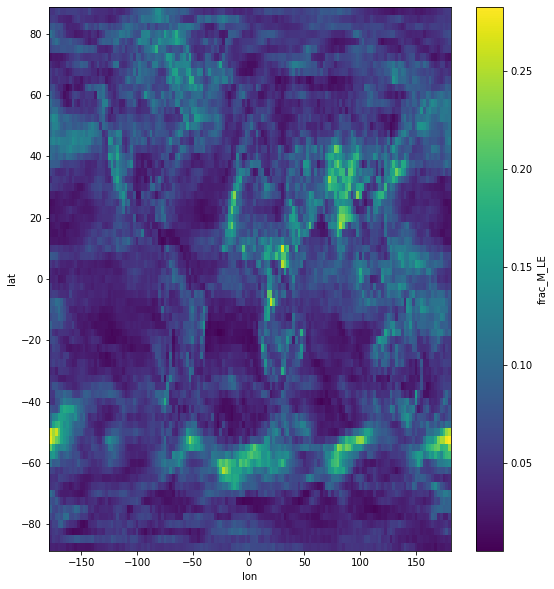

In [197]:
 plt.figure(figsize=(9,10))
results['frac_M_LE'].sel(time=slice('1995', '2014')).mean('time').plot()

In [80]:
import os
import numpy as np
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
cartopy.config['data_dir'] = os.getenv('CARTOPY_DIR', cartopy.config.get('data_dir'))

import cmocean

from matplotlib import pyplot as plt
#%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 


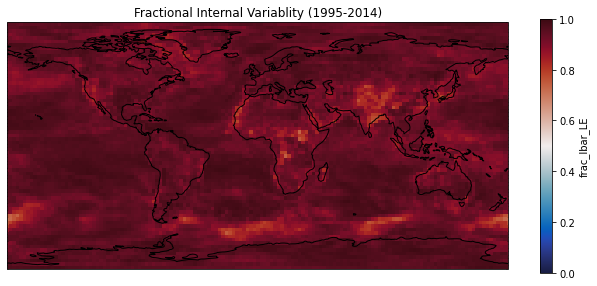

In [178]:
# Figure size
size = (9, 4)

# Color from cmocean
color = cmocean.cm.balance

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree())
# and extent
air = results['frac_Ibar_LE'].sel(time=slice('1995', '2014')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=True,
    
)
# Title

ax.set_ylabel('latitude')
plt.title('Fractional Internal Variablity (1995-2014)',fontsize=12)
# Add map features with Cartopy 
ax.coastlines(linewidth=1)
plt.tight_layout()
plt.show()

In [196]:
size = (9, 10)

# Color from cmocean
color = 'RdYlBu'

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')
plt.show()

<Figure size 648x720 with 0 Axes>

/tmp/ipykernel_9836/2253931764.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


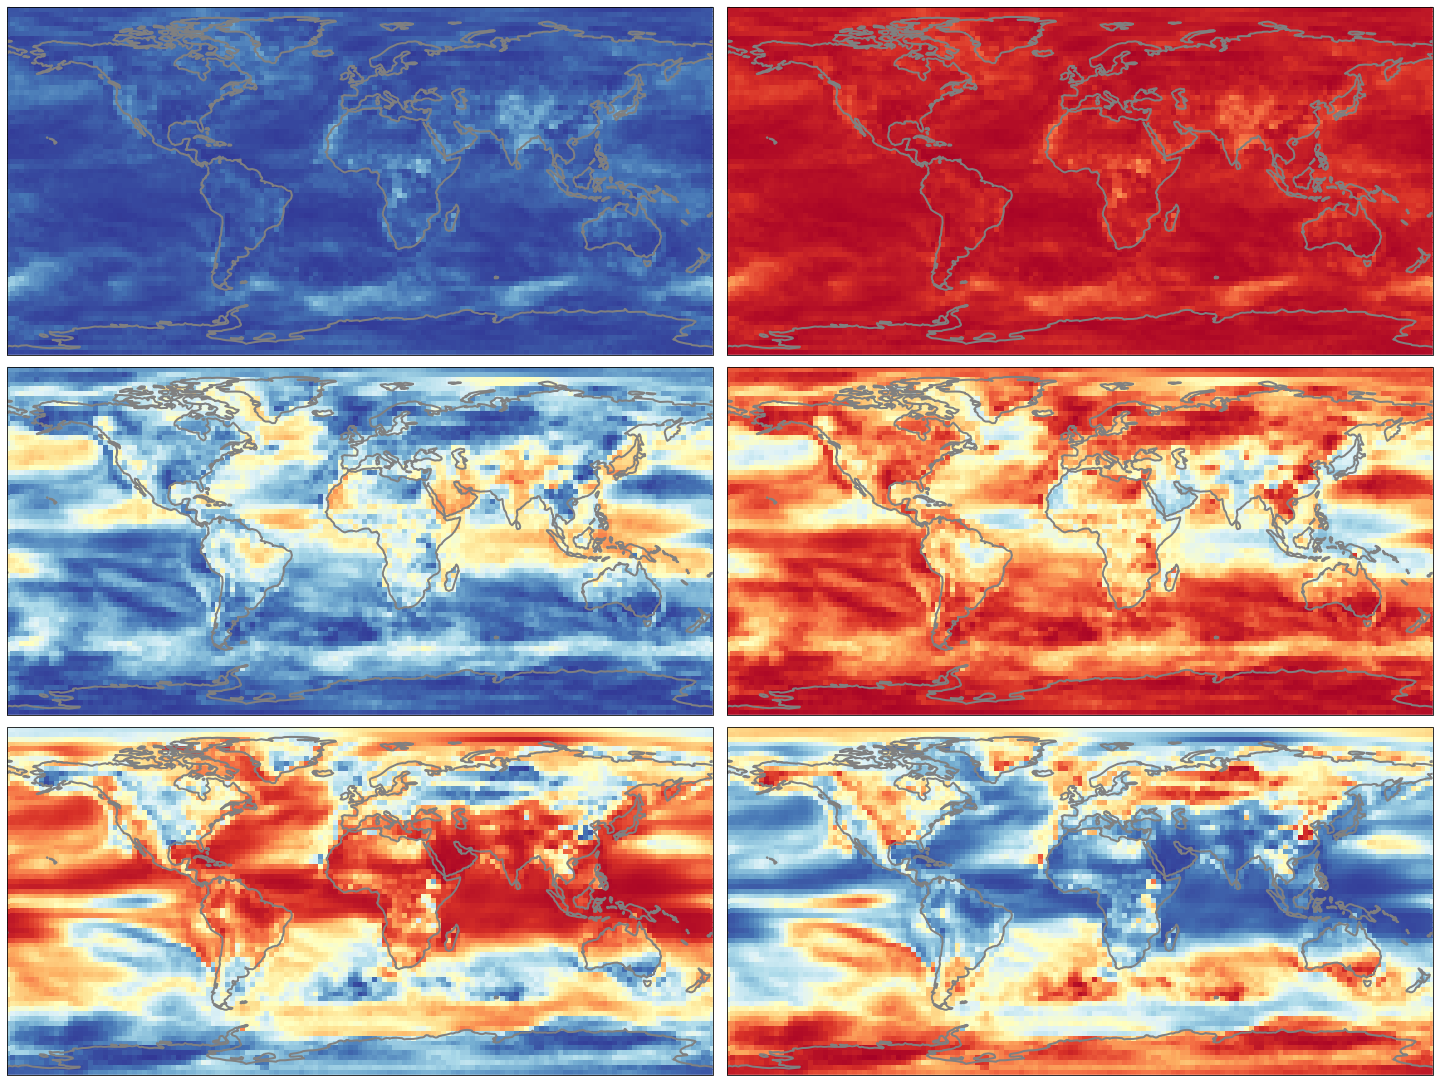

<Figure size 432x288 with 0 Axes>

In [202]:
# # Color bar


# Figure size
size = (10, 10)

# Color from cmocean
color = 'RdYlBu'

# Defining the figure
fig = plt.figure(figsize=size, facecolor='w', edgecolor='k')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree(), arg=(0,1,0.98,0.98))
# and extent
air = results['frac_Ibar_LE'].sel(time=slice('1995', '2014')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=False
)
# Title
# plt.title('Fractional Internal Variablity (1995-2014)',fontsize=12)

# Add map features with Cartopy 
ax.coastlines(linewidth=2, color='gray')


# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree(), arg=(1,1,0.98,0.98))
# and extent
air = results['frac_M_LE'].sel(time=slice('1995', '2014')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=False
)
# plt.title('Fractional Model Uncertainty (1995-2014)', fontsize=12)
ax.coastlines(linewidth=2, color='gray')



# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree(), arg=(0,0.5,0.98,0.98))
# and extent
air = results['frac_Ibar_LE'].sel(time=slice('2015', '2024')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=False
)
# Title
# plt.title('Fractional Internal Variablity (2015-2024)',fontsize=12)

# Add map features with Cartopy 
ax.coastlines(linewidth=2, color='gray')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree(), arg=(1,0.5,0.98,0.98))
# and extent
air = results['frac_M_LE'].sel(time=slice('2015', '2024')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=False
)
# Title
# plt.title('Fractional Model Variablity (2015-2024)',fontsize=12)


# Add map features with Cartopy 
ax.coastlines(linewidth=2, color='gray')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree(), arg=(0,0,0.98,0.98))
# and extent
air = results['frac_Ibar_LE'].sel(time=slice('2035', '2044')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=False
)
# Title
# plt.title('Fractional Internal Variablity (2035-2044)',fontsize=12)

# Add map features with Cartopy 
ax.coastlines(linewidth=2, color='gray')

# Axes with Cartopy projection
ax = plt.axes(projection=ccrs.PlateCarree(), arg=(1,0,0.98,0.98))
# and extent
air = results['frac_M_LE'].sel(time=slice('2035', '2044')).mean('time')
# Plotting using Matplotlib 
# We plot the PH at the surface at the final recorded time interval
cf = air.plot( 
    transform=ccrs.PlateCarree(), cmap=color,
    vmin = 0, vmax = 1,
    add_colorbar=False
)
# Title
# plt.title('Fractional Model Variablity (2035-2044)',fontsize=12)

# Add map features with Cartopy 
ax.coastlines(linewidth=2, color='gray')
# 
# cbar = fig.colorbar(cf, ax=ax, fraction=0.02,
#                     orientation="horizontal")
# cbar.ax.tick_params(labelsize=8)

# # Site Davies Reef
# ax.scatter(-10, 10, c='deeppink', s=50, edgecolors='k', linewidth=1, transform=ccrs.PlateCarree())


plt.tight_layout()
plt.show()
fig.clear()
plt.close(fig)
plt.clf()

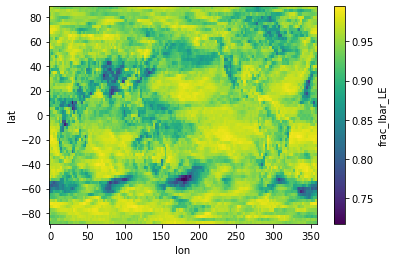

In [30]:
mmle.results['frac_Ibar_LE'].sel(time=slice('1995', '2014')).mean('time').plot()

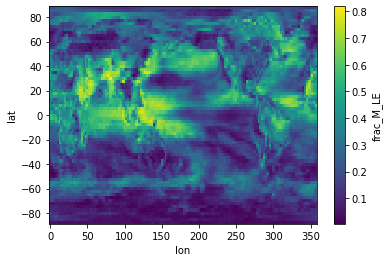

In [26]:
mmle.results['frac_M_LE'].sel(time=slice('2015', '2024')).mean('time').plot()

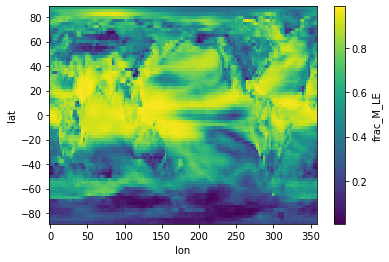

In [27]:
mmle.results['frac_M_LE'].sel(time=slice('2035', '2044')).mean('time').plot()

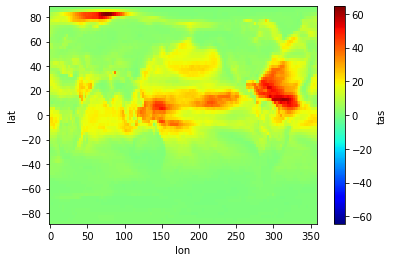

In [18]:
S.sel(time=slice('2015','2024')).mean('time').plot(cmap='jet')

In [92]:
SNR = np.abs(S / np.sqrt(mmle.results['T_LE']))
SNR_ideal = np.abs(S / np.sqrt(mmle.results['Ibar_LE']))

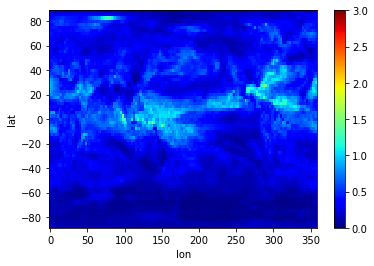

In [99]:
SNR.sel(time=slice('1995', '2015')).mean('time').plot(cmap='jet', vmin=0, vmax=3)

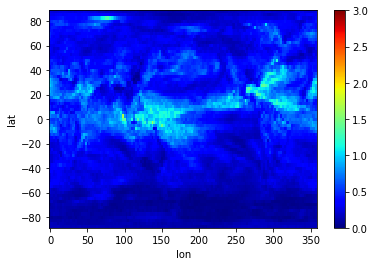

In [100]:
SNR_ideal.sel(time=slice('1995', '2015')).mean('time').plot(cmap='jet', vmin=0, vmax=3)

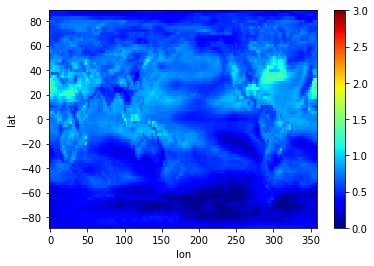

In [101]:
SNR.sel(time=slice('2015', '2025')).mean('time').plot(cmap='jet', vmin=0, vmax=3)

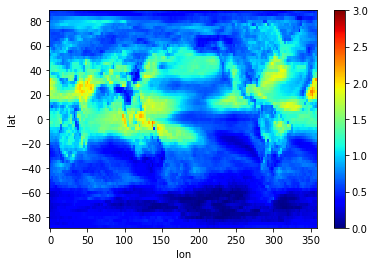

In [102]:
SNR_ideal.sel(time=slice('2015', '2025')).mean('time').plot(cmap='jet', vmin=0, vmax=3)

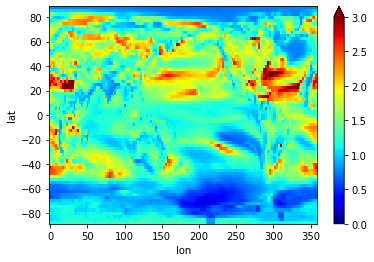

In [103]:
SNR.sel(time=slice('2050', '2059')).mean('time').plot(cmap='jet', vmin=0, vmax=3)

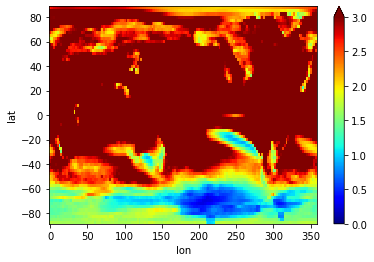

In [104]:
SNR_ideal.sel(time=slice('2050', '2059')).mean('time').plot(cmap='jet', vmin=0, vmax=3)

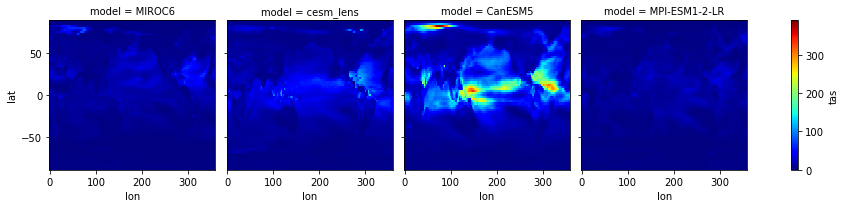

In [54]:
mmle.x.mean('member_id').sel(time=slice('2020', '2029')).mean('time').plot(col='model', cmap='jet')

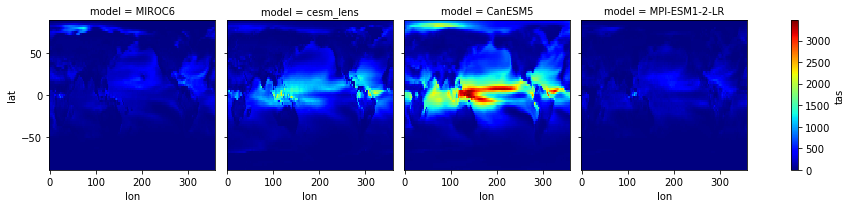

In [55]:
mmle.x.mean('member_id').sel(time=slice('2050', '2059')).mean('time').plot(col='model', cmap='jet')

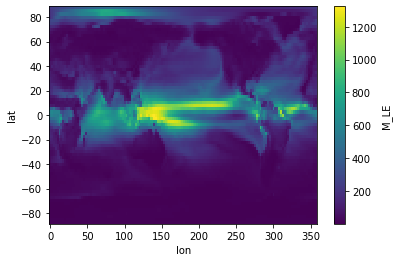

In [50]:
np.sqrt(mmle.results['M_LE']).sel(time=slice('2050', '2059')).mean('time').plot()

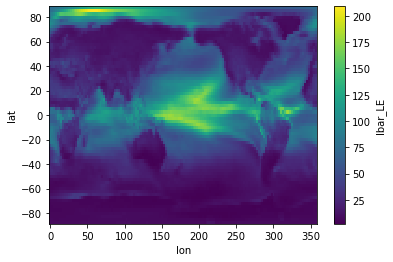

In [51]:
np.sqrt(mmle.results['Ibar_LE']).sel(time=slice('2050', '2059')).mean('time').plot()

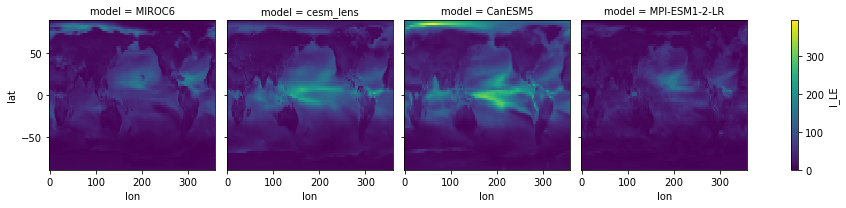

In [56]:
np.sqrt(mmle.results['I_LE']).sel(time=slice('2050', '2059')).mean('time').plot(col='model')

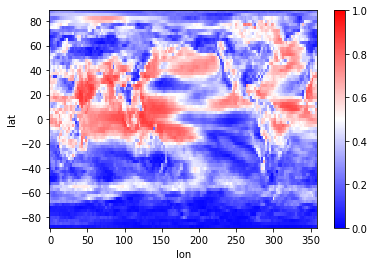

In [47]:
frac.sel(time=slice('2020', '2029')).mean('time').plot(vmin=0, vmax=1, cmap='bwr')

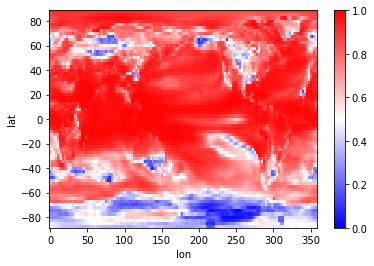

In [48]:
frac.sel(time=slice('2050', '2059')).mean('time').plot(vmin=0, vmax=1, cmap='bwr')

In [67]:
mmle.compute_FIT()

/opt/conda/envs/analogs/lib/python3.9/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


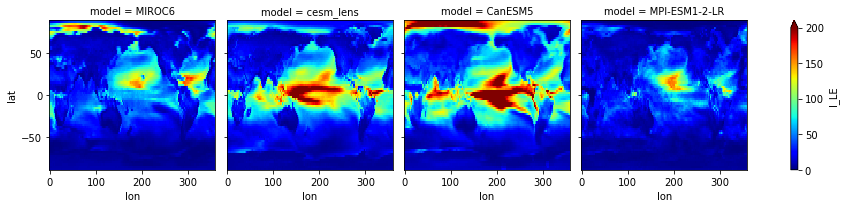

In [69]:
np.sqrt(mmle.results['I_LE']).sel(time=slice('2050', '2059')).mean('time').plot(col='model', vmax=200, cmap='jet')

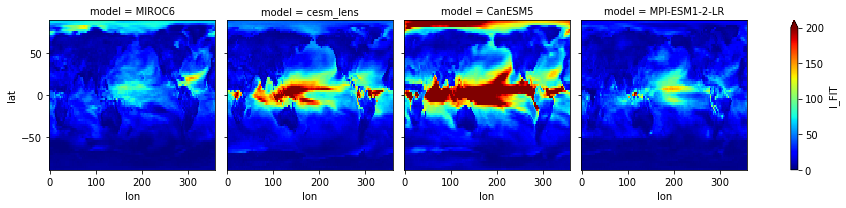

In [70]:
np.sqrt(mmle.results['I_FIT']).plot(col='model', vmax=200, cmap='jet')

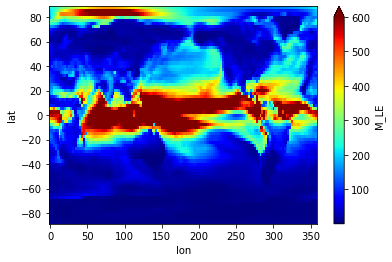

In [74]:
np.sqrt(mmle.results['M_LE']).sel(time=slice('2050', '2059')).mean('time').plot(vmax=600, cmap='jet')

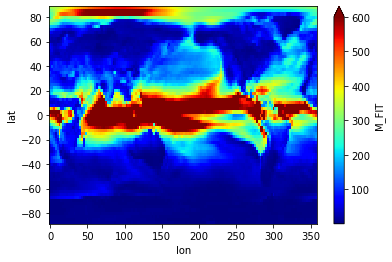

In [75]:
np.sqrt(mmle.results['M_FIT']).sel(time=slice('2050', '2059')).mean('time').plot(vmax=600, cmap='jet')

## CMIP

In [148]:
xr.open_zarr('gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/ssp585/day/pr.zarr')

,Array,Chunk
Bytes,4.73 GiB,5.92 MiB
Shape,"(2, 1, 31046, 71, 144)","(1, 1, 31046, 5, 5)"
Count,871 Tasks,870 Chunks
Type,float64,numpy.ndarray


In [151]:
mmle = MultiModelLargeEnsemble('cmip6', 'pr', 'day', 
                               lat=50, lon=10, 
                               bucket='climateai_data_repository', path='tmp/global_cmip_2.5deg')

gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/historical/day/pr.zarr gcs://climateai_data_repository/tmp/global_cmip_2.5deg/cmip6/ssp585/day/pr.zarr


In [136]:
mmle.compute_x(x_type='quantile_return')

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


8.77109146118164


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


8.769718170166016


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


8.67263412475586


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


8.796646118164062


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


8.792858123779297


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


8.843666076660156


100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


8.893852233886719


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


8.909076690673828


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


8.908771514892578


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


8.749980926513672


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


8.748424530029297


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


8.796974182128906


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


8.79703140258789


  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/utils.py:35: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/opt/conda/envs/analogs/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

8.795394897460938


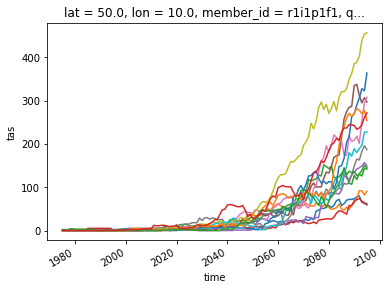

In [139]:
mmle.x.plot(hue='model', add_legend=False);

In [141]:
mmle.compute_FIT()

/opt/conda/envs/analogs/lib/python3.9/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [142]:
mmle.results

<xarray.Dataset>
Dimensions:    (model: 14, lat: 1, lon: 1, time: 130)
Coordinates:
  * model      (model) <U30 'INM-CM4-8' 'INM-CM5-0' ... 'GFDL-ESM4' 'NorESM2-MM'
  * lat        (lat) float64 50.0
  * lon        (lon) float64 10.0
  * time       (time) datetime64[ns] 1970-01-01 1971-01-01 ... 2099-01-01
    member_id  <U8 'r1i1p1f1'
    quantile   float64 0.9997
    q_values   (model, lat, lon) float64 307.3 305.9 307.9 ... 296.8 297.1 300.8
Data variables:
    FIT        (time, model, lat, lon) float64 0.2374 3.388 ... 155.1 324.9
    M_FIT      (time, lat, lon) float64 192.9 144.2 ... 1.661e+04 1.812e+04
    I_FIT      (model, lat, lon) float64 30.74 53.36 126.4 ... 334.6 86.37 175.8
    Ibar_FIT   (lat, lon) float64 146.2
    T_FIT      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan